In [39]:
import os

import imageio
import matplotlib
%matplotlib inline

from sklearn import metrics
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
import numpy as np
import cv2

from sklearn.metrics import confusion_matrix, average_precision_score, f1_score, precision_score, recall_score, precision_recall_curve, auc
from scipy.spatial.transform import Rotation

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

params = {'lines.markersize':30}
matplotlib.rcParams.update(params)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.express as px
import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [40]:
#path = '/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_sift'
path = "/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Can/1000/captures_can_1000_sift"

In [41]:
def PDKP(GT, Pred, diagonals, th):
    poseDi = np.linalg.norm((GT - Pred), axis=2)
    
    KPNum = np.array(np.where(poseDi < (th * diagonals), 1, 0))
    per = np.sum(KPNum)/len(poseDi.ravel())
    
    return per, KPNum

def fallOff(GT, Pred, objectArea):
    
    dLen = GT.shape[0]
    num_classes = GT.shape[1]
    finalStd = []
    
    for i in ['norm', 'norm_Axis0', 'norm_Axis1', 'sub', 'abs_sub']:
        StdDevKeypoints = np.ones((num_classes))
        ## Calclulating the standard deviation 
        ##https://books.google.de/books?id=oTBGRJI7gIMC&lpg=PA179&ots=Kt65nd30rN&dq=how%20to%20calculate%20the%20standard%20deviation%20of%20human%20pose&pg=PA179#v=onepage&q&f=false
        #http://cocodataset.org/#keypoints-eval
        for n in range(0, num_classes):
            gtD = []
            pedD = []
            for d2 in range(0, dLen):
                gtD.append(GT[d2][n])
                pedD.append(Pred[d2][n])
                
            if i == 'norm':
                StdDevKeypoints[n] = np.std(np.divide(np.linalg.norm(np.asarray(gtD) - np.asarray(pedD)),objectArea))
            elif i == 'norm_Axis0':
                StdDevKeypoints[n] = np.std(np.divide(np.linalg.norm(np.asarray(gtD) - np.asarray(pedD), axis=0),objectArea))
            elif i == 'norm_Axis1':
                StdDevKeypoints[n] = np.std(np.divide(np.linalg.norm(np.asarray(gtD) - np.asarray(pedD), axis=1),objectArea))
            elif i == 'sub':
                StdDevKeypoints[n] = np.std(np.divide((np.asarray(gtD) - np.asarray(pedD)),objectArea))
            elif i == 'abs_sub':
                StdDevKeypoints[n] = np.std(np.divide(abs(np.asarray(gtD) - np.asarray(pedD)),objectArea))
            
        finalStd.append(StdDevKeypoints)
               
    finalStd = np.array(finalStd).T
    finalStd = np.mean(finalStd, axis=1)                                
    #print(finalStd.shape)                                        
    return finalStd

def pixelDeviation(GT, Pred, objectArea):
    
    dLen = GT.shape[0]
    num_classes = GT.shape[1]
    finalStd = []
    
    for i in ['norm', 'norm_Axis0', 'norm_Axis1', 'sub', 'abs_sub']:
        StdDevKeypoints = np.ones((num_classes))
        ## Calclulating the standard deviation 
        ##https://books.google.de/books?id=oTBGRJI7gIMC&lpg=PA179&ots=Kt65nd30rN&dq=how%20to%20calculate%20the%20standard%20deviation%20of%20human%20pose&pg=PA179#v=onepage&q&f=false
        #http://cocodataset.org/#keypoints-eval
        for n in range(0, num_classes):
            gtD = []
            for d2 in range(0, dLen):
                gtD.append(GT[d2][n])
            StdDevKeypoints[n] = np.std(np.divide(gtD, objectArea))
            
        finalStd.append(StdDevKeypoints)
               
    finalStd = np.array(finalStd).T
    finalStd = np.mean(finalStd)                                
    #print(finalStd.shape, finalStd)                                        
    return finalStd

def stdDev(path, algo = 'SemanticKDD', ver='v1', ty = 'Synth'):

    output_folder = os.path.join(path, 'output')

    data_file = '{}/{}_{}_{}-finaldata{}.npy'.format(output_folder, ty, 0, algo, ver)
    print('data file ', data_file)
    data = np.load(data_file,  allow_pickle = True ).item()

    GroundTruthPoints = data['GTPoints']
    PredcitedPoints = data['PPoints']
    ReprojectedPoints = data['RPPoints']
    objectArea = data['ObjectArea']

    stdDev = fallOff(GroundTruthPoints, PredcitedPoints, objectArea)

    return stdDev, pixelDeviation(GroundTruthPoints, PredcitedPoints, objectArea)

def OKS(GT, Pred, objectArea, StdDevKeypoints):
    
    dLen = GT.shape[0]
    num_classes = GT.shape[1]
    
    OKS = np.ones((dLen, num_classes))

    #StdDevKeypoints = falOff(GT, Pred, objectArea, dLen, num_classes)
    for d1 in range(0, dLen):
        OKS[d1] = np.exp(-np.divide((np.linalg.norm(GT[d1] - Pred[d1], axis=1) ** 2), \
                        (2 *  np.multiply((objectArea[d1] ** 2) , ((2 * StdDevKeypoints) ** 2)))))
        
    return OKS

def precisionRecall(arr, th, plot=False):
    
    pres = []
    recall = []
    r = 0
    for i, t in enumerate(arr):
        pres.append(len(arr[np.where(arr[:i+1] > th)])/(i+1))

        if t > th:  
            r = len(arr[np.where(arr[:i+1] > th)])/len(arr[arr>th])
        recall.append(r)
        
    if plot:
        plt.plot(np.array(pres), np.array(recall), label='PR Curve threshold : {}'.format(th))
        plt.legend()
        plt.show()
    
    return auc(recall, pres), np.mean(recall)
    

def visualizeKP(output_folder , flag , algo = 'SemanticKDD', ver='v1', plot=False):
    #'Synth', 
    for ty in ['Synth','Real']:
        print('************************ {} *********************'.format(ty))    
        print('************************ Keypoint errors *********************')  
        
        kpTy = 'KPDetection_{}'.format(flag) if flag is not None else 'KPDetection_ICP'
        pTy = 'Pose_PnP_{}'.format(flag) if flag is not None else 'Pose_ICP'
        
        avg_file = '{}/{}_{}_{}-avgResults{}.npy'.format(output_folder, ty, kpTy, algo, ver)
        full_file = '{}/{}_{}_{}-fullResults{}.npy'.format(output_folder, ty, kpTy, algo, ver)

        
        avg_details = np.load(avg_file,  allow_pickle = True ).item()
        print('reading file : {} '.format(full_file))
        full_details = np.load(full_file,  allow_pickle = True ).item()
        
        print('\nMSE  IOU')
        print("{} {} \n".format(avg_details['MSE'], np.mean(full_details['IOU'])))
              
        
        for th in [0.5, 0.25]:
            
            OKS_per_KP = full_details['OKS'].ravel()
            mAPOKS, mAROKS = precisionRecall(OKS_per_KP, th, plot=plot)
            
            if plot:
                sns.distplot(OKS_per_KP, label='OKS Density: {}'.format(th), fit=norm ,kde=True, hist=False);
                plt.legend()
                plt.show()
            
            ## IOU based matrix 
            IOUsKP = np.array(full_details['IOU'])
            mAPIOU, mARIOU = precisionRecall(IOUsKP, th)
            
            if plot :
                sns.distplot(IOUsKP, label='IOU Density : {}'.format(th), fit=norm,  kde=True, hist=False);
                plt.legend()
                plt.show()
                
            print('\nThreashold {} : OKS mAP : OKS mRP : IOU mAP : IOU mAR'.format(th))
            print("{} {} {} {} \n".format(mAPOKS, mAROKS, mAPIOU, mARIOU))
        

def visualizePose(output_folder , flag , algo = 'SemanticKDD', ver='v1', plot=False):
    #'Synth', 
    for ty in ['Real']:
        print('************************ {} ********************* \n'.format(ty))    
        print('************************ Pose errors *********************')  
        
        pTy = 'Pose_PnP_{}'.format(flag) if flag is not None else 'Pose_ICP'
        
        avg_file = '{}/{}_{}_{}-avgResults{}.npy'.format(output_folder, ty, pTy, algo, ver)
        full_file = '{}/{}_{}_{}-fullResults{}.npy'.format(output_folder, ty, pTy, algo, ver)

        print('reading file : {} '.format(avg_file))
        avg_details = np.load(avg_file,  allow_pickle = True).item()
        
        print('reading file : {} '.format(full_file))
        full_details = np.load(full_file,  allow_pickle = True).item()
        
        print('\nThreashold {} : RotErr : TransError : IOU : Rperror')
        print("{} {} {} {} \n".format(avg_details['RotError'], avg_details['TransError'], avg_details['IOU'], avg_details['Reprojection error']))
        
        for th in [0.5, 0.25]:
        
            OKS_per_KP = full_details['OKS'].ravel()
            mAPOKS, mAROKS = precisionRecall(OKS_per_KP, th, plot=plot)
            
            if plot:
                sns.distplot(OKS_per_KP, label='OKS Density: {}'.format(th), fit=norm ,kde=True, hist=False);
                plt.legend()
                plt.show()
            
            ## IOU based matrix 
            IOUsKP = np.array(full_details['IOU'])
            mAPIOU, mARIOU = precisionRecall(IOUsKP, th, plot=plot)
            
            if plot :
                sns.distplot(IOUsKP, label='IOU Density: {}'.format(th), fit=norm,  kde=True, hist=False);
                plt.legend()
                plt.show()
            
            #print(np.mean(recall))
            #print(len(IOUsKP[IOUsKP > th])/len(IOUsKP), average_precision_score(np.ones(IOUsKP.shape), np.where()))

            print('\nThreashold {} : OKS mAP : OKS mRP : IOU mAP : IOU mAR'.format(th))
            print("{} {} {} {} \n".format(mAPOKS, mAROKS, mAPIOU, mARIOU))
    
   

In [62]:

def KEypointsResult():
    plt.figure(figsize=(15, 10))
    print('\n*********************************** KP Errors ***********************************')
    for ty in ['Real', 'Synth']:
        print('\n=======================',ty,'=======================')
        for i, path in enumerate(paths):

            output_folder = os.path.join(path, 'output')
            std_dev, pixel_dev = stdDev(path, ty=ty)
            #print(np.mean(std_dev), pixel_dev)

            if i == 0:
                col = 'blue'
                f = ' Random'

            elif i == 1:
                col = 'green'
                f = ' Sift'

            label = ty + f

            for flag in [cv2.SOLVEPNP_EPNP]:

                kpTy = 'KPDetection_{}'.format(flag) if flag is not None else 'KPDetection_ICP'

                avg_file = '{}/{}_{}_{}-avgResults{}.npy'.format(output_folder, ty, kpTy, algo, ver)
                full_file = '{}/{}_{}_{}-fullResults{}.npy'.format(output_folder, ty, kpTy, algo, ver)
                data_file = '{}/{}_{}_{}-finaldata{}.npy'.format(output_folder, ty, flag, algo, ver)

                #print('loading ', avg_file)
                data = np.load(data_file,  allow_pickle = True ).item()
                avg_details = np.load(avg_file,  allow_pickle = True ).item()
                full_details = np.load(full_file,  allow_pickle = True ).item()

                GroundTruthPoints = data['GTPoints']
                PredcitedPoints = data['PPoints']

                objectArea = data['ObjectArea']
                diagonals = data['Diagonal']

                if flag == cv2.SOLVEPNP_EPNP:
                    if ty == 'Real':
                        m1 = "$RP_e$"
                        m2 = "$RO_e$"
                    elif ty == 'Synth':
                        m1 = "$SP_e$"
                        m2 = "$SO_e$"

                    l1 = label + '-EPNP:PCK'
                    l2 = label + '-EPNP:OKS'
                else:
                    m1 = "$PCK_i$"
                    l1 = label + '-Iterative:PCK'
                    m2 = "$OKS_i$"
                    l2 = label + '-Iterative:OKS'

                oks = OKS(GroundTruthPoints, PredcitedPoints, objectArea, std_dev)
                oksPercentage = np.sum(np.where(oks > th, 1, 0))/len(oks.ravel())

                KPPer, KPArr = PDKP(GroundTruthPoints, PredcitedPoints, diagonals, KPth)

                iou = full_details['IOU']

                print('\n-------------',f,'--------------\n')
                print('MSE %.4f\n'%(avg_details['MSE']))
                print('OKS \t\t PCK \t\t IOU')
                print('%.4f \t\t %.4f \t %.4f'%(oksPercentage, KPPer, np.mean(iou)))

                mAPOKS, mAROKS = precisionRecall(oks.ravel(), th)
                mAPCPK, mARPCK = precisionRecall(KPArr.ravel(), th)
                mAPIOU, mARIOU = precisionRecall(iou, th)


                print('\nMAP_OKS \t MAP_PCK \t MAP_IOU')
                print('%.4f \t\t %.4f \t %.4f'%(mAPOKS, mAPCPK, mAPIOU))

                plt.scatter(x = pixel_dev, y = KPPer, c=col, marker=m1, label=l1)
                #plt.scatter(x = pixel_dev, y = oksPercentage, c=col, marker=m2, label=l2)
                
    plt.xlabel('Mean Pixel deviation')
    plt.ylabel('% detected keypoints')

    #plt.xlim(0, 0.010)
    plt.legend(fontsize="x-large")
    plt.show()

In [63]:
def PoseResult():
    dataTrans = []
    print('\n*********************************** POSE Errors ***********************************')
    for ty in ['Real', 'Synth']:
        print('\n=======================',ty,'=======================')
        for i, path in enumerate(paths):

            output_folder = os.path.join(path, 'output')
            std_dev, p = stdDev(path)

            if i == 0:
                col = 'green'
                f = 'Random'

            elif i == 1:
                col = 'blue'
                f = 'SURF'

            label =  f

            for flag in [cv2.SOLVEPNP_ITERATIVE, cv2.SOLVEPNP_EPNP]:

                pTy = 'Pose_PnP_{}'.format(flag) if flag is not None else 'Pose_ICP'

                avg_file = '{}/{}_{}_{}-avgResults{}.npy'.format(output_folder, ty, pTy, algo, ver)
                full_file = '{}/{}_{}_{}-fullResults{}.npy'.format(output_folder, ty, pTy, algo, ver)
                data_file = '{}/{}_{}_{}-finaldata{}.npy'.format(output_folder, ty, flag, algo, ver)

                #print('loading ', avg_file)
                data = np.load(data_file,  allow_pickle = True ).item()
                avg_details = np.load(avg_file,  allow_pickle = True ).item()
                full_details = np.load(full_file,  allow_pickle = True ).item()
                
                GroundTruthPoints = data['GTPoints']
                ReprojectedPoints = data['RPPoints']

                objectArea = data['ObjectArea']
                diagonals = data['Diagonal']

                if flag == cv2.SOLVEPNP_EPNP:
                    if ty == 'Real':
                        m1 = "$RP_e$"
                        m2 = "$RO_e$"
                    elif ty == 'Synth':
                        m1 = "$SP_e$"
                        m2 = "$SO_e$"

                    l1 = label 
                    l2 = label + '-EPNP:OKS'
                else:
                    if ty == 'Real':
                        m1 = "$RP_i$"
                        m2 = "$RO_i$"
                    elif ty == 'Synth':
                        m1 = "$SP_i$"
                        m2 = "$SO_i$"

                    l1 = label + '-Iterative'
                    l2 = label + '-Iterative:OKS'

                oks = OKS(GroundTruthPoints, ReprojectedPoints, objectArea, std_dev)
                oksPercentage = np.sum(np.where(oks > th, 1, 0))/len(oks.ravel())

                KPPer, KPArr = PDKP(GroundTruthPoints, ReprojectedPoints, diagonals, KPth)

                iou = full_details['IOU']

                print('\n-------------',f ,':', flag,'--------------\n')
                print('\nRotErr \t\t TransError\t Rperror')
                print("%.4f \t\t %.4f \t %.4f \n"%(avg_details['RotError'], avg_details['TransError'], avg_details['Reprojection error']))
                
                print('OKS \t\t PCK \t\t IOU')
                print('%.4f \t\t %.4f \t %.4f'%(oksPercentage, KPPer, np.mean(iou)))

                mAPOKS, mAROKS = precisionRecall(oks.ravel(), th)
                mAPCPK, mARPCK = precisionRecall(KPArr.ravel(), th)
                mAPIOU, mARIOU = precisionRecall(iou, th)


                print('\nMAP_OKS \t MAP_PCK \t MAP_IOU')
                print('%.4f \t\t %.4f \t %.4f'%(mAPOKS, mAPCPK, mAPIOU))
                
                var = abs(full_details['RotErrors'] - avg_details['RotError']) ** 2
                
                #dataTrans.append(go.Histogram(x=(full_details['TransErrors'] - avg_details['TransError']), histnorm='probability',marker_color=col, name=l1, legendgroup=ty))
                plt.scatter(x = avg_details['Reprojection error'], y = mAPCPK, c=col, marker=m1, label=l1)
                plt.scatter(x = avg_details['Reprojection error'], y = mAPOKS, c=col, marker=m2, label=l2)
                #plt.scatter(full_details['Reprojection errors'], var)
                
    plt.xlabel('Reprojection error')
    plt.ylabel('% detected keypoints')

    plt.xlim(0, 0.002)
    plt.legend(fontsize="x-large")
    
    plt.show()
#     fig = go.Figure(data=dataTrans)
    
#     fig.update_xaxes(title="Translation Error (mm) of Real data - EPNP Method ")
#     fig.update_yaxes(title="Probability")
    
#     fig.update_layout(
#     autosize=False,
#     width=1024,
#     height=512,
#     legend=dict(
#             x=0.85,
#             y=0.95,
# #             traceorder="normal",
# #             font=dict(
# #                 family="sans-serif",
# #                 size=12,
# #                 color="black"
# #             ),
# #             bgcolor="LightSteelBlue",
# #             bordercolor="Black",
# #             borderwidth=2
#         )
#     )
        
#     fig.write_image("Translation_random_surf.png")


*********************************** KP Errors ***********************************

======================= Real =======================
data file  /home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_random/output/Real_0_SemanticKDD-finaldatav1.npy

-------------  Random --------------

MSE 0.0016

OKS 		 PCK 		 IOU
0.9437 		 0.0980 	 0.1416

MAP_OKS 	 MAP_PCK 	 MAP_IOU
0.9455 		 0.0844 	 0.0000
data file  /home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_sift/output/Real_0_SemanticKDD-finaldatav1.npy

-------------  Sift --------------

MSE 0.0016

OKS 		 PCK 		 IOU
0.9549 		 0.1820 	 0.1056

MAP_OKS 	 MAP_PCK 	 MAP_IOU
0.9399 		 0.2513 	 0.0000

======================= Synth =======================
data file  /home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_random/output/Synth_0_SemanticKDD-finaldatav1.npy

-------------  Random --------------

MSE 

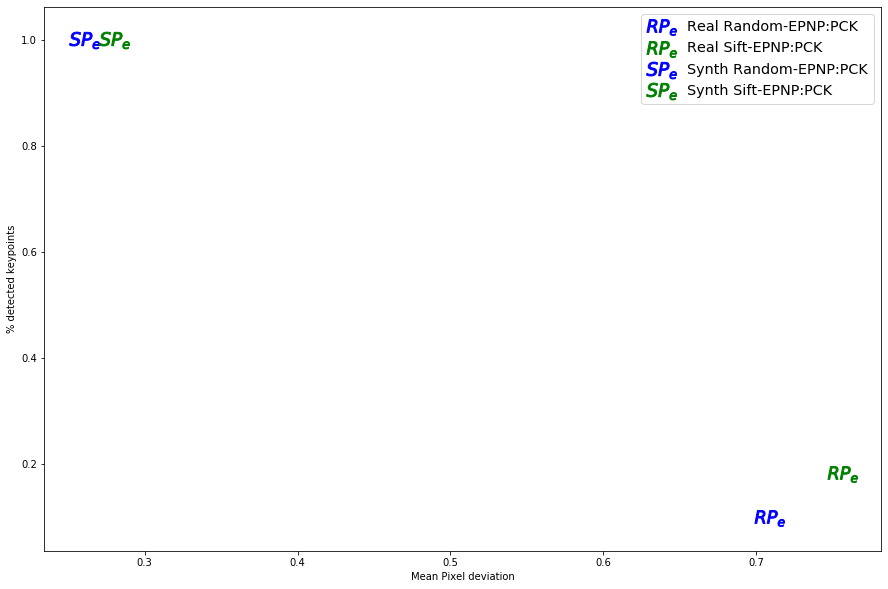


*********************************** POSE Errors ***********************************

======================= Real =======================
data file  /home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_random/output/Synth_0_SemanticKDD-finaldatav1.npy

------------- Random : 0 --------------


RotErr 		 TransError	 Rperror
2.0699 		 1732.8278 	 0.2182 

OKS 		 PCK 		 IOU
0.0020 		 0.0294 	 0.0451

MAP_OKS 	 MAP_PCK 	 MAP_IOU
0.0018 		 0.0276 	 0.0000

------------- Random : 1 --------------


RotErr 		 TransError	 Rperror
2.2707 		 1148.5578 	 0.2148 

OKS 		 PCK 		 IOU
0.0016 		 0.0298 	 0.0455

MAP_OKS 	 MAP_PCK 	 MAP_IOU
0.0011 		 0.0281 	 0.0000
data file  /home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_sift/output/Synth_0_SemanticKDD-finaldatav1.npy

------------- SURF : 0 --------------


RotErr 		 TransError	 Rperror
2.4819 		 1366.8793 	 0.2073 

OKS 		 PCK 		 IOU
0.0010 		 0.0098 	 0.05

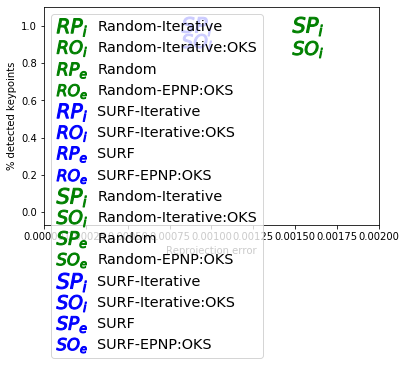

In [64]:

paths = ["/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_random",\
                                "/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_sift"]

# paths = ["/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Can/1000/captures_can_1000_random",\
#                                   "/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Can/1000/captures_can_1000_sift"]

#paths = ["/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Duck/100"]

algo = 'SemanticKDD'
ver='v1'
ty = 'Real'
th = 0.50
KPth = 0.05


KEypointsResult()
PoseResult()